In [ ]:
!pip install lightgbm optuna
!pip install optuna-integration[lightgbm]
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import optuna
from optuna.integration import LightGBMPruningCallback
import sys

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 2.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Senior_Thesis_Waseda/exp_religion')

In [ ]:
%run ../evaluation.ipynb
%run ../training.ipynb
%run ../parameter_optimization.ipynb

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Senior_Thesis_Waseda/happiness_data.csv')
df.head()
df.shape

(97220, 82)

In [ ]:
income = pd.read_csv('/content/drive/MyDrive/Senior_Thesis_Waseda/happiness_data_pre_cluster.csv')
income = income.loc[:, ['D_INTERVIEW','Q173P']]
income.head()

,D_INTERVIEW,Q173P
0,196070011,3
1,196070036,3
2,196070039,3
3,196070040,3
4,196070053,3


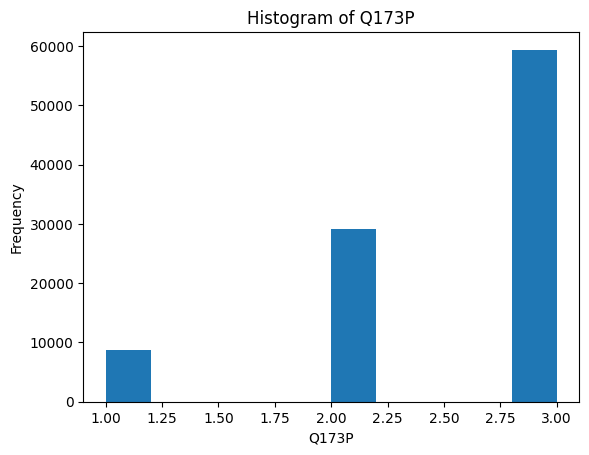

In [ ]:
import matplotlib.pyplot as plt

plt.hist(income['Q173P'])
plt.xlabel('Q173P')
plt.ylabel('Frequency')
plt.title('Histogram of Q173P')
plt.show()

In [ ]:
df_merged = pd.merge(income, df, on='D_INTERVIEW')
df_merged.head()

,D_INTERVIEW,Q173P,happiness,B_COUNTRY_ALPHA,G_TOWNSIZE,GDP group,H_SETTLEMENT,Cl_1,Cl_2,Cl_3,...,Cl_67,Cl_68,Cl_69,Cl_70,Cl_71,Cl_72,Cl_73,Cl_74,Cl_75,Cl_76
0,196070011,3,7.333333,CYP,6.0,1,4.0,0.936297,-0.623011,-1.308899,...,-1.675059,0.345000,0.976462,-1.848202,-1.456204,0.884878,2,1,6,3
1,196070036,3,8.000000,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,0.580208,-0.332603,0.976462,-1.218074,-0.272563,0.884878,1,1,8,3
2,196070039,3,8.000000,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,0.574066,0.146194,-0.200705,-0.266231,0.323946,0.268851,1,1,0,3
3,196070040,3,5.333333,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,-0.009851,0.143230,0.976462,-0.742153,-0.272563,0.884878,1,1,8,3
4,196070053,3,4.000000,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,0.507466,-0.300418,0.386842,0.839819,0.915767,0.268851,2,5,8,3


In [ ]:
df_merged = df_merged[df_merged['Q173P'] == 3]
df_merged.head()

,D_INTERVIEW,Q173P,happiness,B_COUNTRY_ALPHA,G_TOWNSIZE,GDP group,H_SETTLEMENT,Cl_1,Cl_2,Cl_3,...,Cl_67,Cl_68,Cl_69,Cl_70,Cl_71,Cl_72,Cl_73,Cl_74,Cl_75,Cl_76
0,196070011,3,7.333333,CYP,6.0,1,4.0,0.936297,-0.623011,-1.308899,...,-1.675059,0.345000,0.976462,-1.848202,-1.456204,0.884878,2,1,6,3
1,196070036,3,8.000000,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,0.580208,-0.332603,0.976462,-1.218074,-0.272563,0.884878,1,1,8,3
2,196070039,3,8.000000,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,0.574066,0.146194,-0.200705,-0.266231,0.323946,0.268851,1,1,0,3
3,196070040,3,5.333333,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,-0.009851,0.143230,0.976462,-0.742153,-0.272563,0.884878,1,1,8,3
4,196070053,3,4.000000,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,0.507466,-0.300418,0.386842,0.839819,0.915767,0.268851,2,5,8,3


In [ ]:
categorical = ['Cl_73', 'Cl_74', 'Cl_75', 'Cl_76']

for col in categorical:
    if col in df.columns:
        df[col] = df[col].astype('category')

In [ ]:
X = df_merged.loc[:, 'Cl_1':]
y = df_merged['happiness']

In [ ]:
parameter_optimization(X, y,
    save_path="exp_religious_best_params.json")

[I 2025-06-15 05:51:26,893] A new study created in memory with name: lgbm_regression_opt


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.519988
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.517228
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.509569
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.50837
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.516123


[I 2025-06-15 05:59:04,680] Trial 0 finished with value: 0.5142555411316554 and parameters: {'num_leaves': 37, 'learning_rate': 0.059662768998574464, 'max_depth': 12, 'reg_alpha': 0.01689821456403644, 'reg_lambda': 0.008733286960935062, 'feature_fraction': 0.5545578611806954, 'bagging_fraction': 0.7944205512826226, 'bagging_freq': 4, 'min_data_in_leaf': 483}. Best is trial 0 with value: 0.5142555411316554.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.553046
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.548966
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.543281
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.541544
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.546844


[I 2025-06-15 06:09:17,907] Trial 1 finished with value: 0.5467360629075356 and parameters: {'num_leaves': 124, 'learning_rate': 0.008135993077935482, 'max_depth': 11, 'reg_alpha': 0.00016165526881359486, 'reg_lambda': 0.7035409156988579, 'feature_fraction': 0.4019026700531766, 'bagging_fraction': 0.5756856352296862, 'bagging_freq': 5, 'min_data_in_leaf': 459}. Best is trial 0 with value: 0.5142555411316554.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.01744
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.01303
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.00887
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.00922
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.0152


[I 2025-06-15 06:21:20,010] Trial 2 finished with value: 1.0127512247488557 and parameters: {'num_leaves': 59, 'learning_rate': 0.0031419355583659327, 'max_depth': 9, 'reg_alpha': 8.662924996503568, 'reg_lambda': 0.02194583099502228, 'feature_fraction': 0.47397242771581266, 'bagging_fraction': 0.9496188320394634, 'bagging_freq': 7, 'min_data_in_leaf': 153}. Best is trial 0 with value: 0.5142555411316554.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.5237
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.52092
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.51964
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.519
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.52252


[I 2025-06-15 06:28:04,633] Trial 3 finished with value: 1.5211543876917166 and parameters: {'num_leaves': 88, 'learning_rate': 0.0020393416894354194, 'max_depth': 3, 'reg_alpha': 0.004180382606157517, 'reg_lambda': 9.005175761589022, 'feature_fraction': 0.7078847726835956, 'bagging_fraction': 0.9258973847512997, 'bagging_freq': 1, 'min_data_in_leaf': 156}. Best is trial 0 with value: 0.5142555411316554.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.51728
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[490]	valid's rmse: 0.514527
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.508601
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.506447
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.511655


[I 2025-06-15 06:41:39,498] Trial 4 finished with value: 0.5117019784550151 and parameters: {'num_leaves': 81, 'learning_rate': 0.03338461566965746, 'max_depth': 12, 'reg_alpha': 0.009228237972087388, 'reg_lambda': 4.420164028591646, 'feature_fraction': 0.6997672062599631, 'bagging_fraction': 0.8812298141809676, 'bagging_freq': 7, 'min_data_in_leaf': 251}. Best is trial 4 with value: 0.5117019784550151.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.03655
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.02846
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.02869
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.02982
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.03555


[I 2025-06-15 06:53:43,041] Trial 5 finished with value: 1.0318146282437506 and parameters: {'num_leaves': 131, 'learning_rate': 0.0035756793567883233, 'max_depth': 6, 'reg_alpha': 0.0003352532574306502, 'reg_lambda': 0.04127989591553768, 'feature_fraction': 0.7891048128108265, 'bagging_fraction': 0.9397669501941917, 'bagging_freq': 1, 'min_data_in_leaf': 169}. Best is trial 4 with value: 0.5117019784550151.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.523649
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.522147
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.514499
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.512469
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.519071


[I 2025-06-15 07:00:25,191] Trial 6 finished with value: 0.5183670325078613 and parameters: {'num_leaves': 30, 'learning_rate': 0.07511737052942642, 'max_depth': 12, 'reg_alpha': 0.0009040884568982261, 'reg_lambda': 5.889870175124454, 'feature_fraction': 0.6664289643882277, 'bagging_fraction': 0.5580546342887509, 'bagging_freq': 5, 'min_data_in_leaf': 200}. Best is trial 4 with value: 0.5117019784550151.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.514416
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.511976
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.50638
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.503402
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.508223


[I 2025-06-15 07:16:20,905] Trial 7 finished with value: 0.5088793588826844 and parameters: {'num_leaves': 149, 'learning_rate': 0.021584729121977998, 'max_depth': 12, 'reg_alpha': 7.376024827825465, 'reg_lambda': 0.0008077586571489891, 'feature_fraction': 0.6648231984664661, 'bagging_fraction': 0.8036760300859622, 'bagging_freq': 5, 'min_data_in_leaf': 204}. Best is trial 7 with value: 0.5088793588826844.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.521867
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.51949
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.512165
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.510005
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.515047


[I 2025-06-15 07:27:28,450] Trial 8 finished with value: 0.5157147651568715 and parameters: {'num_leaves': 107, 'learning_rate': 0.027521448316098446, 'max_depth': 10, 'reg_alpha': 0.004026360901338699, 'reg_lambda': 0.000305705563511273, 'feature_fraction': 0.9006505683344346, 'bagging_fraction': 0.4151335109209015, 'bagging_freq': 2, 'min_data_in_leaf': 432}. Best is trial 7 with value: 0.5088793588826844.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.32551
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.32148
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.31861
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.31777
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.3237


[I 2025-06-15 07:35:55,477] Trial 9 finished with value: 1.3214160631689746 and parameters: {'num_leaves': 26, 'learning_rate': 0.0024446594456802922, 'max_depth': 7, 'reg_alpha': 0.001499402648929466, 'reg_lambda': 0.006244650388242344, 'feature_fraction': 0.4870981102803031, 'bagging_fraction': 0.4813828127928418, 'bagging_freq': 1, 'min_data_in_leaf': 92}. Best is trial 7 with value: 0.5088793588826844.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 07:36:14,814] Trial 10 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.519168
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.516366
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.509948
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.508347
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.513108


[I 2025-06-15 07:49:05,540] Trial 11 finished with value: 0.5133875182887052 and parameters: {'num_leaves': 72, 'learning_rate': 0.028114034068820244, 'max_depth': 9, 'reg_alpha': 0.18049197303944922, 'reg_lambda': 0.34512409552326406, 'feature_fraction': 0.6296645942023187, 'bagging_fraction': 0.819810144023043, 'bagging_freq': 7, 'min_data_in_leaf': 284}. Best is trial 7 with value: 0.5088793588826844.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 07:49:31,854] Trial 12 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 07:50:43,318] Trial 13 pruned. Trial was pruned at iteration 239.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 07:51:04,894] Trial 14 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 07:51:31,248] Trial 15 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.518756
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.517551
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.508932
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.508568
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid's rmse: 0.5143


[I 2025-06-15 08:06:02,236] Trial 16 finished with value: 0.5136215486905215 and parameters: {'num_leaves': 54, 'learning_rate': 0.04521189109160477, 'max_depth': 10, 'reg_alpha': 0.010061145548751751, 'reg_lambda': 1.7087530489429836, 'feature_fraction': 0.8624086565552432, 'bagging_fraction': 0.9987561539929737, 'bagging_freq': 4, 'min_data_in_leaf': 355}. Best is trial 7 with value: 0.5088793588826844.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 08:06:15,157] Trial 17 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 08:06:41,742] Trial 18 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 08:07:03,342] Trial 19 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 08:07:20,847] Trial 20 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.516258
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.515568
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.50809
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.505655
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.510531


[I 2025-06-15 08:19:49,898] Trial 21 finished with value: 0.5112202975604165 and parameters: {'num_leaves': 77, 'learning_rate': 0.039278950418040956, 'max_depth': 9, 'reg_alpha': 0.14154405943530612, 'reg_lambda': 0.2835833892843662, 'feature_fraction': 0.6345014591864532, 'bagging_fraction': 0.7960179725530865, 'bagging_freq': 7, 'min_data_in_leaf': 281}. Best is trial 7 with value: 0.5088793588826844.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.517355
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid's rmse: 0.514926
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.506645
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.506538
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.51309


[I 2025-06-15 08:31:55,303] Trial 22 finished with value: 0.5117108634784212 and parameters: {'num_leaves': 81, 'learning_rate': 0.04676998078903025, 'max_depth': 12, 'reg_alpha': 0.007933178836437677, 'reg_lambda': 0.217074541962206, 'feature_fraction': 0.7252140483203631, 'bagging_fraction': 0.759508442563944, 'bagging_freq': 7, 'min_data_in_leaf': 209}. Best is trial 7 with value: 0.5088793588826844.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.516313
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.51467
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.506737
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.505737
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.510386


[I 2025-06-15 08:43:51,362] Trial 23 finished with value: 0.5107687016071034 and parameters: {'num_leaves': 91, 'learning_rate': 0.04103250762123793, 'max_depth': 9, 'reg_alpha': 0.029136420576304948, 'reg_lambda': 1.6031421014353249, 'feature_fraction': 0.6714426247822578, 'bagging_fraction': 0.7539027784631227, 'bagging_freq': 6, 'min_data_in_leaf': 314}. Best is trial 7 with value: 0.5088793588826844.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[487]	valid's rmse: 0.516903
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[488]	valid's rmse: 0.514201
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.505241
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.504663
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[486]	valid's rmse: 0.508455


[I 2025-06-15 08:54:15,984] Trial 24 finished with value: 0.5098928257687287 and parameters: {'num_leaves': 108, 'learning_rate': 0.06336694819664737, 'max_depth': 9, 'reg_alpha': 3.867755526076228, 'reg_lambda': 0.9348406243708022, 'feature_fraction': 0.51214378803766, 'bagging_fraction': 0.7500665176846019, 'bagging_freq': 6, 'min_data_in_leaf': 316}. Best is trial 7 with value: 0.5088793588826844.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.51839
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[480]	valid's rmse: 0.518087
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.509445
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.505933
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid's rmse: 0.512954


[I 2025-06-15 09:02:45,597] Trial 25 finished with value: 0.512961985860354 and parameters: {'num_leaves': 112, 'learning_rate': 0.0689947499119543, 'max_depth': 7, 'reg_alpha': 3.102862430394538, 'reg_lambda': 1.1012547397820738, 'feature_fraction': 0.5237386913304256, 'bagging_fraction': 0.6473414417901787, 'bagging_freq': 6, 'min_data_in_leaf': 397}. Best is trial 7 with value: 0.5088793588826844.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 09:03:05,253] Trial 26 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[363]	valid's rmse: 0.520433
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[318]	valid's rmse: 0.519885
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[316]	valid's rmse: 0.506969
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[362]	valid's rmse: 0.508652
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[339]	valid's rmse: 0.514976


[I 2025-06-15 09:11:08,550] Trial 27 finished with value: 0.5141833337731543 and parameters: {'num_leaves': 101, 'learning_rate': 0.09727263951888995, 'max_depth': 10, 'reg_alpha': 0.4489930658218551, 'reg_lambda': 0.6979216351910185, 'feature_fraction': 0.5215785828356199, 'bagging_fraction': 0.6742675373732645, 'bagging_freq': 4, 'min_data_in_leaf': 305}. Best is trial 7 with value: 0.5088793588826844.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 09:11:26,891] Trial 28 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.516043
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.512802
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.504937
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.504737
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.510551


[I 2025-06-15 09:23:54,378] Trial 29 finished with value: 0.5098138759481876 and parameters: {'num_leaves': 89, 'learning_rate': 0.05773555104787926, 'max_depth': 9, 'reg_alpha': 0.016748804018540543, 'reg_lambda': 0.006769296221162642, 'feature_fraction': 0.5666674144463874, 'bagging_fraction': 0.83145617369267, 'bagging_freq': 3, 'min_data_in_leaf': 492}. Best is trial 7 with value: 0.5088793588826844.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.514352
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.512348
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.504871
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.503552
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.50813


[I 2025-06-15 09:36:32,973] Trial 30 finished with value: 0.5086506700240573 and parameters: {'num_leaves': 117, 'learning_rate': 0.05416760778554196, 'max_depth': 11, 'reg_alpha': 0.02068436492353106, 'reg_lambda': 0.005613260916303199, 'feature_fraction': 0.5276954989256775, 'bagging_fraction': 0.8358762287099257, 'bagging_freq': 3, 'min_data_in_leaf': 484}. Best is trial 30 with value: 0.5086506700240573.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.515666
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	valid's rmse: 0.512994
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[484]	valid's rmse: 0.505178
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[489]	valid's rmse: 0.50393
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	valid's rmse: 0.509257


[I 2025-06-15 09:49:17,441] Trial 31 finished with value: 0.5094047857262576 and parameters: {'num_leaves': 118, 'learning_rate': 0.06560133321203092, 'max_depth': 11, 'reg_alpha': 0.020562720191030094, 'reg_lambda': 0.005834874830062052, 'feature_fraction': 0.5562561434765995, 'bagging_fraction': 0.834583676975722, 'bagging_freq': 3, 'min_data_in_leaf': 499}. Best is trial 30 with value: 0.5086506700240573.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.517094
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[485]	valid's rmse: 0.513757
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[483]	valid's rmse: 0.506877
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[488]	valid's rmse: 0.50712
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[478]	valid's rmse: 0.509125


[I 2025-06-15 10:02:12,403] Trial 32 finished with value: 0.5107945658585836 and parameters: {'num_leaves': 120, 'learning_rate': 0.06850364285859653, 'max_depth': 11, 'reg_alpha': 0.027575211704022252, 'reg_lambda': 0.007079144567549899, 'feature_fraction': 0.5689862759122511, 'bagging_fraction': 0.8274542616475469, 'bagging_freq': 3, 'min_data_in_leaf': 499}. Best is trial 30 with value: 0.5086506700240573.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.513802
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[489]	valid's rmse: 0.511894
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.502842
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.503185
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.505869


[I 2025-06-15 10:15:19,694] Trial 33 finished with value: 0.5075182600650574 and parameters: {'num_leaves': 141, 'learning_rate': 0.055348064221671406, 'max_depth': 11, 'reg_alpha': 0.01649153560255409, 'reg_lambda': 0.0031614397971445577, 'feature_fraction': 0.4434841609807767, 'bagging_fraction': 0.9099609216639752, 'bagging_freq': 2, 'min_data_in_leaf': 463}. Best is trial 33 with value: 0.5075182600650574.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.513146
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.511544
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.502796
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.501502
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.505968


[I 2025-06-15 10:28:44,355] Trial 34 finished with value: 0.5069909744796599 and parameters: {'num_leaves': 144, 'learning_rate': 0.04787505781832714, 'max_depth': 11, 'reg_alpha': 0.002925275967233839, 'reg_lambda': 0.003630094813429288, 'feature_fraction': 0.4213294088347218, 'bagging_fraction': 0.9125287951573587, 'bagging_freq': 2, 'min_data_in_leaf': 460}. Best is trial 34 with value: 0.5069909744796599.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.51385
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.511159
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.502273
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.500826
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid's rmse: 0.506248


[I 2025-06-15 10:42:32,737] Trial 35 finished with value: 0.5068712855861611 and parameters: {'num_leaves': 141, 'learning_rate': 0.05207474281564236, 'max_depth': 12, 'reg_alpha': 0.0017410022677353176, 'reg_lambda': 0.0024921940391654427, 'feature_fraction': 0.4220016202109254, 'bagging_fraction': 0.9072278735900791, 'bagging_freq': 2, 'min_data_in_leaf': 449}. Best is trial 35 with value: 0.5068712855861611.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.512903
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.510306
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.50263
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.501371
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	valid's rmse: 0.505535


[I 2025-06-15 10:56:04,208] Trial 36 finished with value: 0.5065490457333269 and parameters: {'num_leaves': 139, 'learning_rate': 0.050336151209315796, 'max_depth': 11, 'reg_alpha': 0.0017917926649241515, 'reg_lambda': 0.0029059229967816364, 'feature_fraction': 0.40284523386126636, 'bagging_fraction': 0.9780905058095504, 'bagging_freq': 2, 'min_data_in_leaf': 454}. Best is trial 36 with value: 0.5065490457333269.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 10:56:28,542] Trial 37 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 10:56:50,450] Trial 38 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.514311
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[334]	valid's rmse: 0.514584
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.504264
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[404]	valid's rmse: 0.503397
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[435]	valid's rmse: 0.50684


[I 2025-06-15 11:08:49,655] Trial 39 finished with value: 0.5086793482123466 and parameters: {'num_leaves': 128, 'learning_rate': 0.08225333469786428, 'max_depth': 12, 'reg_alpha': 0.00035662533552227214, 'reg_lambda': 0.0005319487950328531, 'feature_fraction': 0.40839559058719765, 'bagging_fraction': 0.9662743414379078, 'bagging_freq': 2, 'min_data_in_leaf': 421}. Best is trial 36 with value: 0.5065490457333269.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid's rmse: 0.513258
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.511842
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.501923
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.50108
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.506477


[I 2025-06-15 11:19:53,393] Trial 40 finished with value: 0.5069159878266021 and parameters: {'num_leaves': 142, 'learning_rate': 0.04622882397917265, 'max_depth': 12, 'reg_alpha': 0.002952985549282697, 'reg_lambda': 0.0031245570226166165, 'feature_fraction': 0.458951730679064, 'bagging_fraction': 0.913561203796598, 'bagging_freq': 1, 'min_data_in_leaf': 464}. Best is trial 36 with value: 0.5065490457333269.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.512408
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.511017
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.502772
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[490]	valid's rmse: 0.499823
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[476]	valid's rmse: 0.506887


[I 2025-06-15 11:30:57,148] Trial 41 finished with value: 0.5065815018651266 and parameters: {'num_leaves': 143, 'learning_rate': 0.05354110885317198, 'max_depth': 12, 'reg_alpha': 0.002744139702871481, 'reg_lambda': 0.0026098615404809076, 'feature_fraction': 0.4727314560868313, 'bagging_fraction': 0.9059398134214978, 'bagging_freq': 1, 'min_data_in_leaf': 463}. Best is trial 36 with value: 0.5065490457333269.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 11:31:19,181] Trial 42 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.5123
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[488]	valid's rmse: 0.510948
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.501378
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.500119
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.505474


[I 2025-06-15 11:42:36,362] Trial 43 finished with value: 0.5060438731189424 and parameters: {'num_leaves': 143, 'learning_rate': 0.045755593804781565, 'max_depth': 12, 'reg_alpha': 0.0005917863029624189, 'reg_lambda': 0.021583016288281708, 'feature_fraction': 0.4839885407213522, 'bagging_fraction': 0.8981040649483256, 'bagging_freq': 1, 'min_data_in_leaf': 466}. Best is trial 43 with value: 0.5060438731189424.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 11:42:57,691] Trial 44 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 11:43:16,676] Trial 45 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[488]	valid's rmse: 0.515248
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[360]	valid's rmse: 0.515239
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.504917
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[491]	valid's rmse: 0.503914
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[352]	valid's rmse: 0.511299


[I 2025-06-15 11:52:47,169] Trial 46 finished with value: 0.5101233024875134 and parameters: {'num_leaves': 134, 'learning_rate': 0.08629112674239722, 'max_depth': 12, 'reg_alpha': 0.0006315096715653641, 'reg_lambda': 0.0007805843061286276, 'feature_fraction': 0.4660136340322638, 'bagging_fraction': 0.9831869754126981, 'bagging_freq': 1, 'min_data_in_leaf': 470}. Best is trial 43 with value: 0.5060438731189424.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 11:53:06,097] Trial 47 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 11:53:26,321] Trial 48 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 11:53:49,668] Trial 49 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.512538
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.512537
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.502787
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid's rmse: 0.50248
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[485]	valid's rmse: 0.508108


[I 2025-06-15 12:03:43,350] Trial 50 finished with value: 0.5076900286068188 and parameters: {'num_leaves': 131, 'learning_rate': 0.05215505125153608, 'max_depth': 11, 'reg_alpha': 0.0008074885802032715, 'reg_lambda': 0.0008827067417484918, 'feature_fraction': 0.4002675820457737, 'bagging_fraction': 0.8990264354565832, 'bagging_freq': 1, 'min_data_in_leaf': 481}. Best is trial 43 with value: 0.5060438731189424.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.513755
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.511642
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.502843
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.502408
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.506863


[I 2025-06-15 12:17:01,932] Trial 51 finished with value: 0.5075021722374438 and parameters: {'num_leaves': 145, 'learning_rate': 0.047013464452221, 'max_depth': 11, 'reg_alpha': 0.002914642814022492, 'reg_lambda': 0.004190754570500836, 'feature_fraction': 0.425311666708977, 'bagging_fraction': 0.9261192540735056, 'bagging_freq': 2, 'min_data_in_leaf': 472}. Best is trial 43 with value: 0.5060438731189424.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[493]	valid's rmse: 0.514565
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[392]	valid's rmse: 0.512662
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[487]	valid's rmse: 0.504305
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid's rmse: 0.503635
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[470]	valid's rmse: 0.511391


[I 2025-06-15 12:29:41,631] Trial 52 finished with value: 0.5093115217995081 and parameters: {'num_leaves': 143, 'learning_rate': 0.0783267636502483, 'max_depth': 12, 'reg_alpha': 0.0014727499697043806, 'reg_lambda': 0.00991794541628531, 'feature_fraction': 0.46398679301962276, 'bagging_fraction': 0.8723270610161064, 'bagging_freq': 2, 'min_data_in_leaf': 443}. Best is trial 43 with value: 0.5060438731189424.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 12:30:04,796] Trial 53 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 12:30:28,469] Trial 54 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 12:30:48,079] Trial 55 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 12:31:13,918] Trial 56 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	valid's rmse: 0.514347
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[488]	valid's rmse: 0.512937
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[487]	valid's rmse: 0.505128
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[486]	valid's rmse: 0.503395
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.508812


[I 2025-06-15 12:42:32,346] Trial 57 finished with value: 0.5089238583531493 and parameters: {'num_leaves': 145, 'learning_rate': 0.054424975862850763, 'max_depth': 12, 'reg_alpha': 0.0020698493714588575, 'reg_lambda': 0.010820760710178479, 'feature_fraction': 0.41861545165416203, 'bagging_fraction': 0.4936636744027952, 'bagging_freq': 1, 'min_data_in_leaf': 433}. Best is trial 43 with value: 0.5060438731189424.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 12:42:56,758] Trial 58 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 12:43:16,994] Trial 59 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 12:43:31,429] Trial 60 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 12:43:55,231] Trial 61 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[490]	valid's rmse: 0.512046
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.510531
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.501492
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[488]	valid's rmse: 0.501549
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[490]	valid's rmse: 0.506783


[I 2025-06-15 12:56:03,564] Trial 62 finished with value: 0.5064802623395651 and parameters: {'num_leaves': 148, 'learning_rate': 0.04625355690756666, 'max_depth': 12, 'reg_alpha': 0.002532442875072374, 'reg_lambda': 0.002699084234606821, 'feature_fraction': 0.42049046632489795, 'bagging_fraction': 0.9973537513633176, 'bagging_freq': 2, 'min_data_in_leaf': 44}. Best is trial 43 with value: 0.5060438731189424.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.511885
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	valid's rmse: 0.510384
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.502766
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.500083
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[419]	valid's rmse: 0.506165


[I 2025-06-15 13:08:16,515] Trial 63 finished with value: 0.5062565634386293 and parameters: {'num_leaves': 147, 'learning_rate': 0.049100946267682744, 'max_depth': 12, 'reg_alpha': 0.011228961071917553, 'reg_lambda': 0.0030393350111405197, 'feature_fraction': 0.4608416084031652, 'bagging_fraction': 0.9974914272952841, 'bagging_freq': 2, 'min_data_in_leaf': 41}. Best is trial 43 with value: 0.5060438731189424.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 13:08:37,806] Trial 64 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[433]	valid's rmse: 0.512808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[410]	valid's rmse: 0.512509
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid's rmse: 0.504602
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[422]	valid's rmse: 0.501978
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[467]	valid's rmse: 0.507695


[I 2025-06-15 13:17:37,860] Trial 65 finished with value: 0.5079185191882465 and parameters: {'num_leaves': 135, 'learning_rate': 0.06377014119496004, 'max_depth': 12, 'reg_alpha': 0.0008321105427552466, 'reg_lambda': 0.0011532071591331574, 'feature_fraction': 0.4492788410188129, 'bagging_fraction': 0.9814160393665033, 'bagging_freq': 1, 'min_data_in_leaf': 65}. Best is trial 43 with value: 0.5060438731189424.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 13:18:03,342] Trial 66 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 13:19:16,715] Trial 67 pruned. Trial was pruned at iteration 202.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 13:19:38,199] Trial 68 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 13:19:58,249] Trial 69 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[313]	valid's rmse: 0.515452
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[331]	valid's rmse: 0.514124
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[279]	valid's rmse: 0.507943
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[275]	valid's rmse: 0.505087
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[256]	valid's rmse: 0.508956


[I 2025-06-15 13:26:31,768] Trial 70 finished with value: 0.51031231054411 and parameters: {'num_leaves': 148, 'learning_rate': 0.0824401424124049, 'max_depth': 11, 'reg_alpha': 0.01222160886448665, 'reg_lambda': 0.0009258864980356286, 'feature_fraction': 0.4414902950116552, 'bagging_fraction': 0.9999021759871864, 'bagging_freq': 1, 'min_data_in_leaf': 61}. Best is trial 43 with value: 0.5060438731189424.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.511642
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.510431
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.50326
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[489]	valid's rmse: 0.501338
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.506322


[I 2025-06-15 13:39:16,367] Trial 71 finished with value: 0.506598534579944 and parameters: {'num_leaves': 142, 'learning_rate': 0.050227542931712166, 'max_depth': 11, 'reg_alpha': 0.003965769691721437, 'reg_lambda': 0.004956196267127082, 'feature_fraction': 0.4165946887154781, 'bagging_fraction': 0.9142238771901736, 'bagging_freq': 2, 'min_data_in_leaf': 406}. Best is trial 43 with value: 0.5060438731189424.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.512038
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.510364
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[487]	valid's rmse: 0.502388
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[489]	valid's rmse: 0.501577
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.507611


[I 2025-06-15 13:52:31,396] Trial 72 finished with value: 0.5067956494085435 and parameters: {'num_leaves': 142, 'learning_rate': 0.051088585738582645, 'max_depth': 12, 'reg_alpha': 0.0020505443845619275, 'reg_lambda': 0.004765405234655562, 'feature_fraction': 0.4146595245945936, 'bagging_fraction': 0.8996938606402684, 'bagging_freq': 2, 'min_data_in_leaf': 408}. Best is trial 43 with value: 0.5060438731189424.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.512666
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[489]	valid's rmse: 0.512239
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.503972
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.500848
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.50671


[I 2025-06-15 14:05:08,269] Trial 73 finished with value: 0.5072869801567575 and parameters: {'num_leaves': 132, 'learning_rate': 0.05135246339647125, 'max_depth': 11, 'reg_alpha': 0.001842398377756118, 'reg_lambda': 0.0017409528861236682, 'feature_fraction': 0.420773122266061, 'bagging_fraction': 0.8887322942732446, 'bagging_freq': 2, 'min_data_in_leaf': 403}. Best is trial 43 with value: 0.5060438731189424.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 14:05:30,529] Trial 74 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[485]	valid's rmse: 0.513222
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[465]	valid's rmse: 0.511877
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid's rmse: 0.503722
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.503352
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.506829


[I 2025-06-15 14:19:13,852] Trial 75 finished with value: 0.5078003102953816 and parameters: {'num_leaves': 138, 'learning_rate': 0.060767076337252084, 'max_depth': 11, 'reg_alpha': 0.004070804611249682, 'reg_lambda': 0.017183613641940095, 'feature_fraction': 0.44615072022487423, 'bagging_fraction': 0.9762222949380135, 'bagging_freq': 2, 'min_data_in_leaf': 424}. Best is trial 43 with value: 0.5060438731189424.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[452]	valid's rmse: 0.514415
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[479]	valid's rmse: 0.514491
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[475]	valid's rmse: 0.504877
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.502024
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[360]	valid's rmse: 0.509627


[I 2025-06-15 14:31:20,675] Trial 76 finished with value: 0.5090866568109428 and parameters: {'num_leaves': 141, 'learning_rate': 0.06888310904972149, 'max_depth': 11, 'reg_alpha': 0.010318354041243621, 'reg_lambda': 0.010201372582684528, 'feature_fraction': 0.4795574841788937, 'bagging_fraction': 0.8739382136715876, 'bagging_freq': 3, 'min_data_in_leaf': 364}. Best is trial 43 with value: 0.5060438731189424.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 14:31:44,895] Trial 77 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 14:32:04,184] Trial 78 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 14:32:29,696] Trial 79 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 14:32:52,454] Trial 80 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 14:33:40,232] Trial 81 pruned. Trial was pruned at iteration 180.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 14:34:32,547] Trial 82 pruned. Trial was pruned at iteration 89.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 14:34:55,885] Trial 83 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 14:35:36,126] Trial 84 pruned. Trial was pruned at iteration 118.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 14:35:55,118] Trial 85 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 14:36:51,432] Trial 86 pruned. Trial was pruned at iteration 95.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 14:37:17,596] Trial 87 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.512789
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[487]	valid's rmse: 0.510383
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid's rmse: 0.502759
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.500964
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[395]	valid's rmse: 0.507987


[I 2025-06-15 14:51:39,209] Trial 88 finished with value: 0.5069763497175706 and parameters: {'num_leaves': 134, 'learning_rate': 0.05894987220749868, 'max_depth': 12, 'reg_alpha': 0.004876801040225671, 'reg_lambda': 0.0006776149809595648, 'feature_fraction': 0.5095832109849134, 'bagging_fraction': 0.9589097748717058, 'bagging_freq': 2, 'min_data_in_leaf': 420}. Best is trial 43 with value: 0.5060438731189424.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 14:52:04,470] Trial 89 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 14:53:03,976] Trial 90 pruned. Trial was pruned at iteration 220.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[459]	valid's rmse: 0.513279
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.511844
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.502817
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid's rmse: 0.501303
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[464]	valid's rmse: 0.507286


[I 2025-06-15 15:08:05,107] Trial 91 finished with value: 0.5073059836053366 and parameters: {'num_leaves': 134, 'learning_rate': 0.05713675374761913, 'max_depth': 12, 'reg_alpha': 0.005369292026969378, 'reg_lambda': 0.0007184277032674693, 'feature_fraction': 0.5106631832965592, 'bagging_fraction': 0.9594273559836086, 'bagging_freq': 2, 'min_data_in_leaf': 418}. Best is trial 43 with value: 0.5060438731189424.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.513693
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.510704
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[487]	valid's rmse: 0.503699
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.502989
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[338]	valid's rmse: 0.509182


[I 2025-06-15 15:21:40,754] Trial 92 finished with value: 0.5080535049120775 and parameters: {'num_leaves': 139, 'learning_rate': 0.06494318282337665, 'max_depth': 12, 'reg_alpha': 0.004831217695378134, 'reg_lambda': 0.0322984618168318, 'feature_fraction': 0.4809808695396509, 'bagging_fraction': 0.9344876268776764, 'bagging_freq': 2, 'min_data_in_leaf': 446}. Best is trial 43 with value: 0.5060438731189424.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 15:22:45,674] Trial 93 pruned. Trial was pruned at iteration 99.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[396]	valid's rmse: 0.513804
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[424]	valid's rmse: 0.514417
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[484]	valid's rmse: 0.504651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[478]	valid's rmse: 0.504169
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[352]	valid's rmse: 0.509226


[I 2025-06-15 15:33:47,998] Trial 94 finished with value: 0.509253457048174 and parameters: {'num_leaves': 130, 'learning_rate': 0.07514639447943254, 'max_depth': 11, 'reg_alpha': 0.0034044112214328594, 'reg_lambda': 0.0014176573382761598, 'feature_fraction': 0.4293463052257633, 'bagging_fraction': 0.8672694790371518, 'bagging_freq': 3, 'min_data_in_leaf': 376}. Best is trial 43 with value: 0.5060438731189424.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 15:34:04,229] Trial 95 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 15:34:31,384] Trial 96 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 15:34:57,167] Trial 97 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 15:35:24,328] Trial 98 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 15:36:51,968] Trial 99 pruned. Trial was pruned at iteration 264.


In [ ]:
model, test_rmse= training(X, y,
    params_json_path="exp_religious_best_params.json",
    save_model_path='exp_religious_model.txt',
    save_log_filename="exp_religious_log.csv")

Training until validation scores don't improve for 50 rounds
[50]	valid's rmse: 0.637105	valid's l2: 0.405902
[100]	valid's rmse: 0.526913	valid's l2: 0.277638
[150]	valid's rmse: 0.51501	valid's l2: 0.265236
[200]	valid's rmse: 0.511643	valid's l2: 0.261779
[250]	valid's rmse: 0.509755	valid's l2: 0.259851
[300]	valid's rmse: 0.508581	valid's l2: 0.258654
[350]	valid's rmse: 0.507925	valid's l2: 0.257988
[400]	valid's rmse: 0.507339	valid's l2: 0.257392
[450]	valid's rmse: 0.507096	valid's l2: 0.257146
[500]	valid's rmse: 0.506781	valid's l2: 0.256827
[550]	valid's rmse: 0.506771	valid's l2: 0.256817
[600]	valid's rmse: 0.506671	valid's l2: 0.256716
[650]	valid's rmse: 0.506454	valid's l2: 0.256495
[700]	valid's rmse: 0.506289	valid's l2: 0.256329
[750]	valid's rmse: 0.506242	valid's l2: 0.256281
Early stopping, best iteration is:
[741]	valid's rmse: 0.506194	valid's l2: 0.256232


In [ ]:
# Compute the standard deviation of y
std_y = y.std()
print(f"The standard deviation of y is: {std_y}")

The standard deviation of y is: 1.8598585783917756


In [ ]:
evaluation(model,
    X.sample(10000),
    name = "exp_religious_results",
    max_display=30)